In [54]:
import os
import sys
import shutil
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import cv2
import importlib
import dbops_updated as dbops

from facelib import FaceRecognizer, FaceDetector
from facelib import get_config
from matplotlib import pyplot as plt
%matplotlib inline

from IPython.display import display
from PIL import Image  # For loading images

import torch


In [2]:
importlib.reload(dbops)  # Reload the module from source

<module 'dbops_updated' from '/home/u1541638/Projects/Data-Mining-Spring-2025-Project/dbops_updated.py'>

In [61]:
TEST_MOVIE = "tt0075314"
CLUSTER_OUTPUT_DIR = "/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output"

In [62]:
movie_ref = dbops.Movie(TEST_MOVIE)
title = movie_ref.get_title()

In [63]:
all_frames = movie_ref.iterate_frames()

embeddings = []
face_ids = []
for frame in tqdm(all_frames):
    for i, face in enumerate(frame.iterate_faces()):
        if i % 2 == 0:
            embeddings.append(face.get_face_embedding().tolist())
            face_ids.append((face.get_frame_index(), face.get_face_index()))


100%|██████████| 2387/2387 [00:55<00:00, 42.86it/s]


In [40]:
embeddings = np.array(embeddings)

In [41]:
embeddings.shape

(1645, 512)

In [43]:
def cluster_faces_dbscan(embeddings, eps=0.3, min_samples=2):
    """
    Clusters face embeddings using DBSCAN with cosine distance.
    """
    cosine_similarities = cosine_similarity(embeddings)
    print(f"Min cosine similarity: {np.min(cosine_similarities)}")
    print(f"Max cosine similarity: {np.max(cosine_similarities)}")

    cosine_distances = 1 - cosine_similarities
    cosine_distances = np.maximum(0, cosine_distances)
    cosine_distances = np.nan_to_num(cosine_distances, nan=1.0)

    dbscan = DBSCAN(metric="precomputed", eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(cosine_distances)
    return labels



In [44]:
labels = cluster_faces_dbscan(embeddings, eps=0.5, min_samples=5)


Min cosine similarity: -0.30804879328628226
Max cosine similarity: 1.0000000000000018


In [45]:
# Group images into clusters
clusters = {}
for id, cluster in zip(face_ids, labels):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(id)
    


Cluster 0 with size 904:


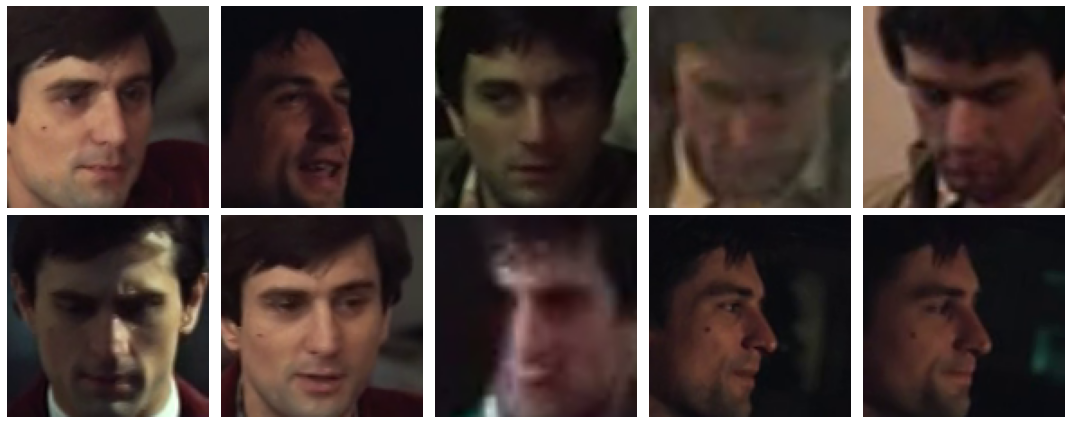


Cluster 1 with size 247:


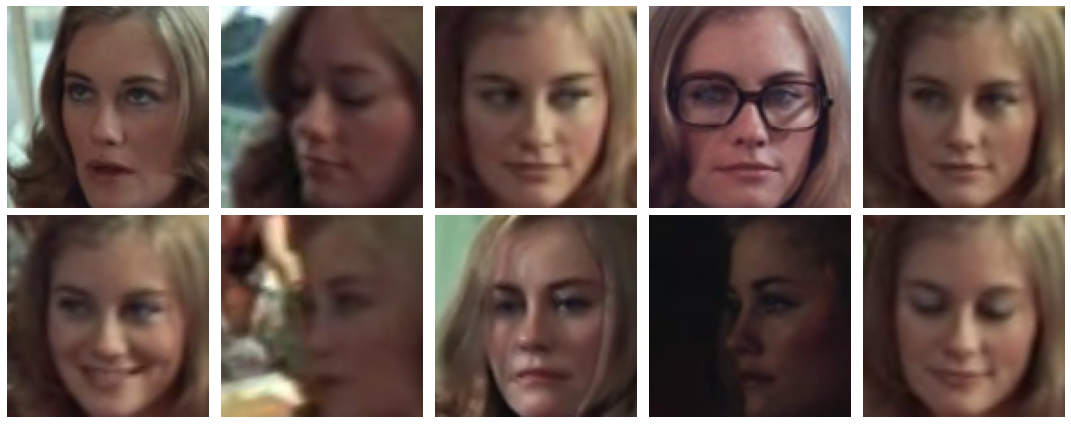


Cluster 2 with size 137:


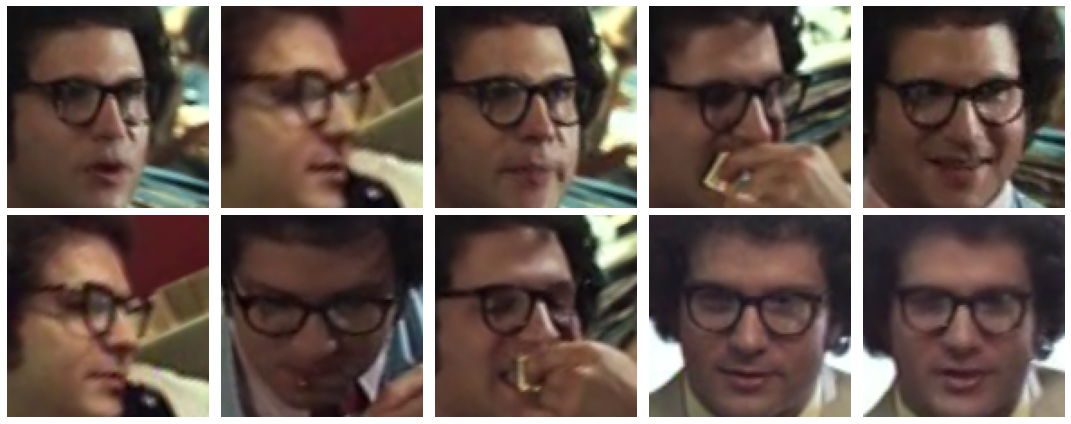


Cluster 3 with size 18:


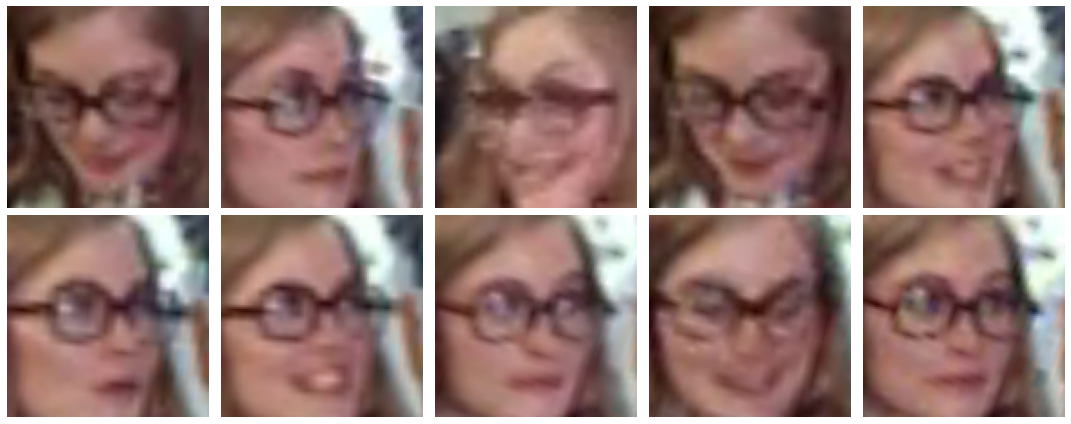


Cluster 4 with size 126:


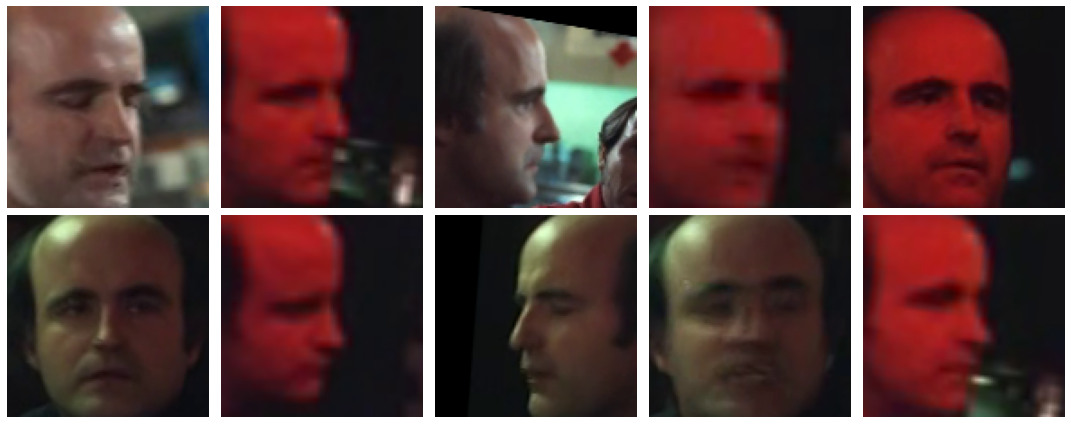


Cluster 5 with size 23:


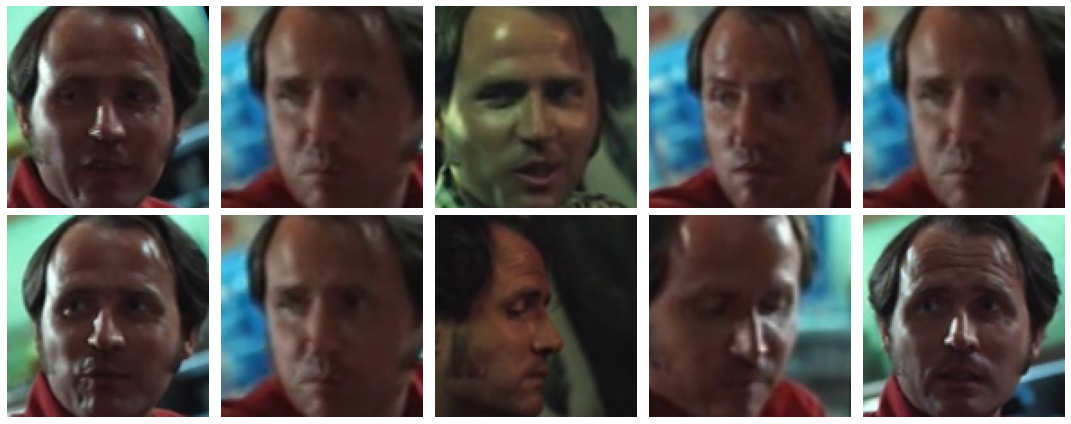


Cluster 7 with size 24:


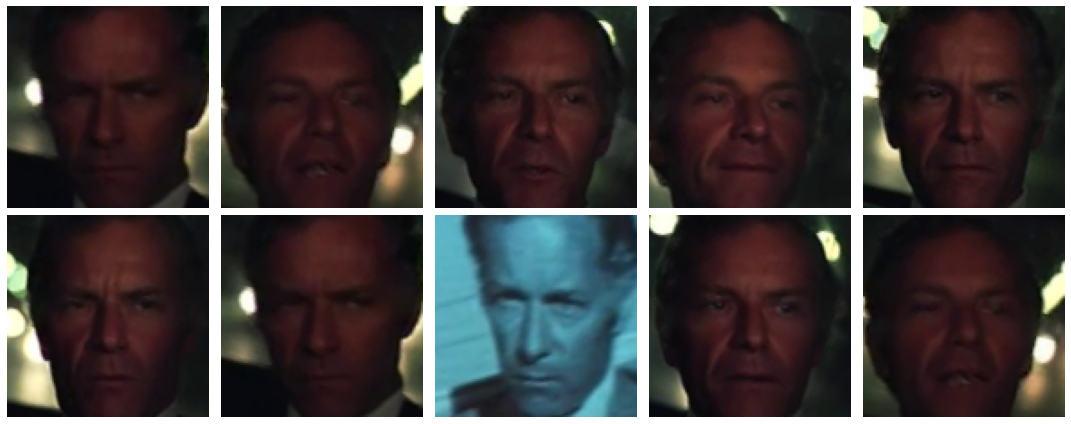


Cluster 6 with size 12:


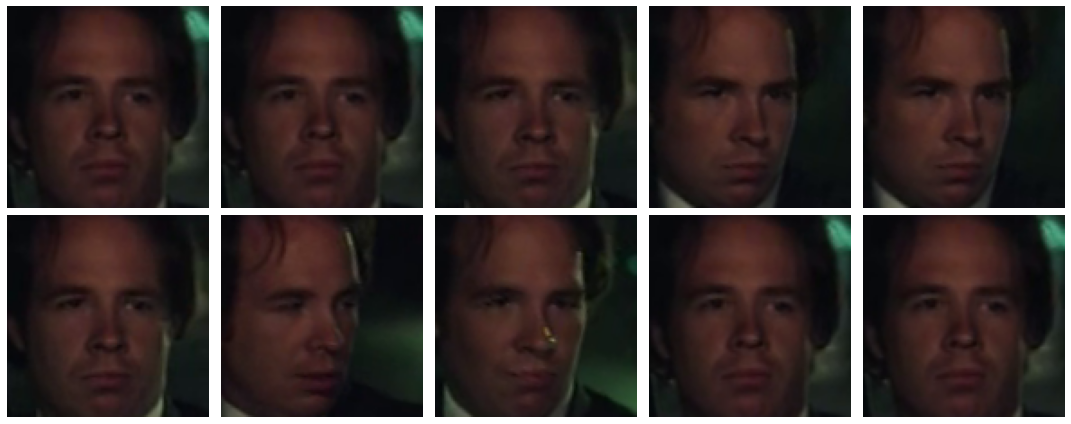


Cluster 8 with size 13:


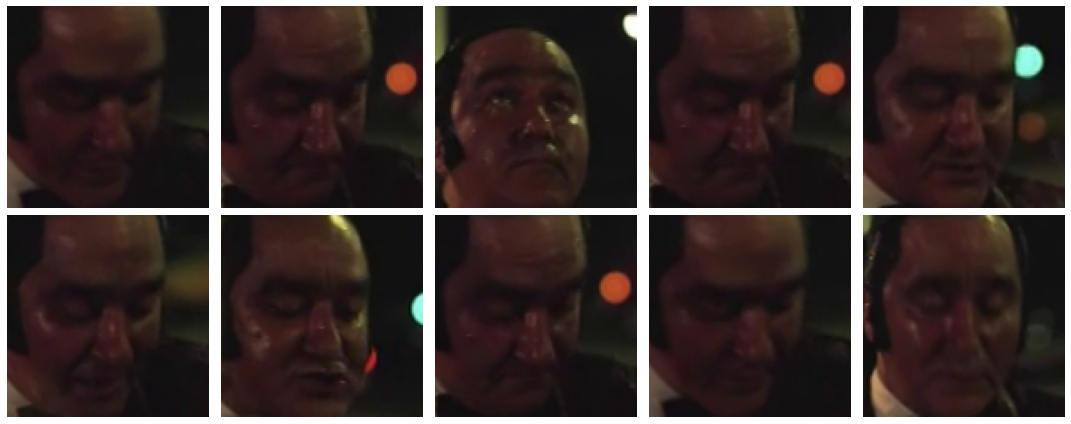


Cluster 9 with size 70:


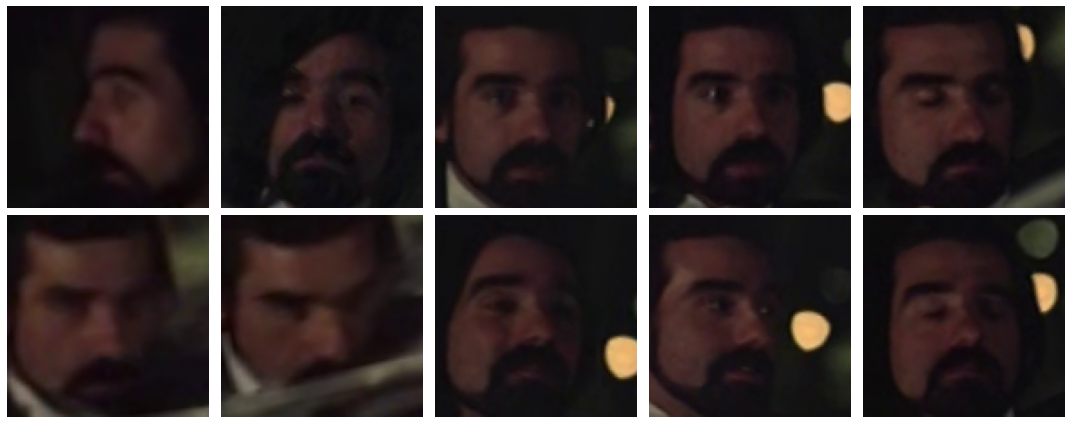


Cluster 10 with size 5:


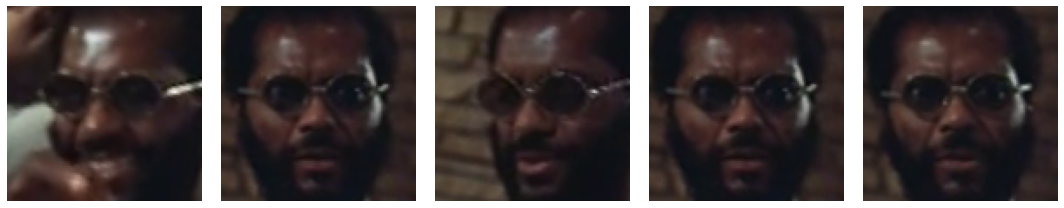


Cluster 11 with size 5:


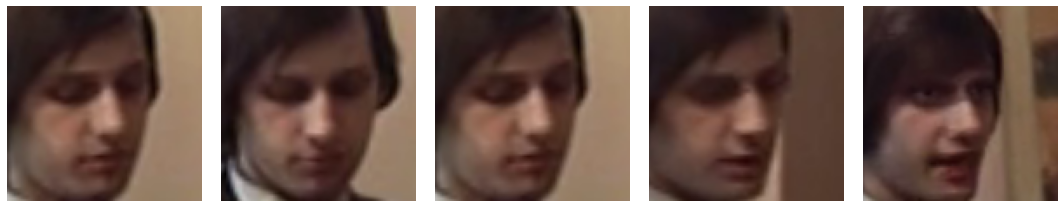


Cluster 12 with size 5:


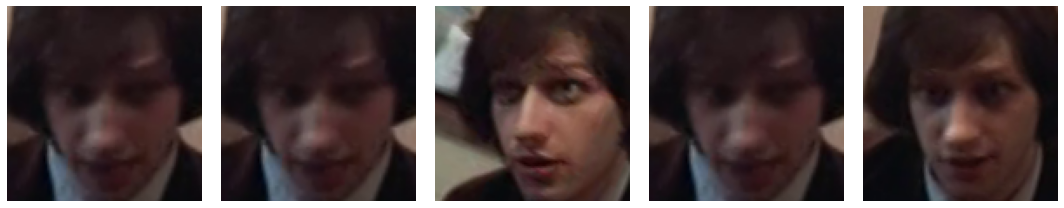

In [67]:
def sample_clusters(clusters, grid_columns=5):
    sample = {}
    for cluster, faces in clusters.items():
        if cluster == -1:
            continue
        print(f"\nCluster {cluster} with size {len(faces)}:")
        sample[cluster] = []

        if faces:
            num_images = min(10, len(faces))  # Display max 10 images
            rows = int(np.ceil(num_images / grid_columns))

            fig, axes = plt.subplots(rows, grid_columns, figsize=(15, 3 * rows))
            axes = axes.flatten()  # Flatten for easier iteration

            for i, ax in enumerate(axes):
                if i < num_images:
                    frame_idx, face_idx = faces[np.random.choice(len(faces))] #get a random face.
                    img = dbops.Face(TEST_MOVIE, frame_idx, face_idx).get_face_image_aligned()
                    sample[cluster].append((frame_idx, face_idx))
                    ax.imshow(np.array(img))  # Convert PIL to NumPy for Matplotlib
                    ax.axis('off') # Hide axes
                else:
                    ax.axis('off')  # Hide unused subplots

            plt.tight_layout()
            plt.show()
    return sample

            
sample = sample_clusters(clusters)

In [70]:
def save_clustered_images(clusters, output_folder):
    """
    Copies images into subfolders based on their cluster labels.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for cluster, faces in clusters.items():
        if cluster == -1:
            continue
        cluster_dir = os.path.join(output_folder, f"cluster_{cluster}")
        if not os.path.exists(cluster_dir):
            os.makedirs(cluster_dir)
        for frame_idx, face_idx in faces:
            img = dbops.Face(TEST_MOVIE, frame_idx, face_idx).get_face_image_aligned()
            img.save(os.path.join(cluster_dir, f"frame_{frame_idx}_face_{face_idx}.jpg"))
            
            

In [71]:
output_directory = os.path.join(CLUSTER_OUTPUT_DIR, title)

save_clustered_images(sample, output_directory)
print(f"Clustered images saved in: {output_directory}")


Clustered images saved in: /scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver
